In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### TODO 
# normalise 0 to mean
# add save model
# egitim cok uzun suruyor on isleme kullanarak egitim zamanini kisalt

In [2]:
ratings_file_path = "../../data/book_x/BX-Book-Ratings.csv"
rating_cols = ['user_id', 'isbn', 'rating']
df = pd.read_csv(ratings_file_path, sep=';', names=rating_cols, encoding='latin-1',low_memory=False, skiprows=1)

In [3]:
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
# print(user2user_encoded)
# print(userencoded2user)

In [4]:
book_ids = df["isbn"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

In [5]:
df["user"] = df["user_id"].map(user2user_encoded)
df["book"] = df["isbn"].map(book2book_encoded)

In [6]:
num_users = len(user2user_encoded)
num_books = len(book2book_encoded)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Books: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_books, min_rating, max_rating
    )
)

Number of users: 105283, Number of Books: 340556, Min rating: 0.0, Max rating: 10.0


In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "book"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.1 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        # Add all the components (including bias)
        x = dot_user_book + user_bias + book_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


In [9]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=1,
    verbose=1,
    validation_data=(x_val, y_val),
)

1797/1797 [==============================] - 542s 302ms/step - loss: 0.6552 - val_loss: 0.5949


In [13]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


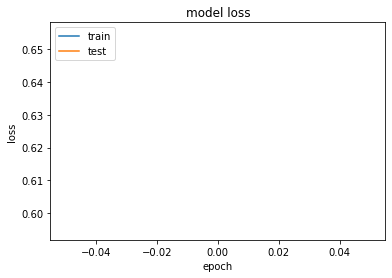

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [19]:
#Books
b_cols = ['isbn', 'title']
book_df = pd.read_csv('../../data/book_x/BX_Books.csv', sep=';', names=b_cols, encoding='latin-1',low_memory=False)
# TODO
# read book csv

# Let us get a user and see the top recommendations.
user_id = df.user_id.sample(1).iloc[0]
books_readed_by_user = df[df.user_id == user_id]
books_not_readed = book_df[
    ~book_df["isbn"].isin(books_readed_by_user.isbn.values)
]["isbn"]

books_not_readed = list(
    set(books_not_readed).intersection(set(book2book_encoded.keys()))
)
books_not_readed = [[book2book_encoded.get(x)] for x in books_not_readed]
user_encoder = user2user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(books_not_readed), books_not_readed)
)
print(user_book_array)

ratings = model.predict(user_book_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded2book.get(books_not_readed[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("books with high ratings from user")
print("----" * 8)
top_books_user = (
    books_readed_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .bookId.values
)
book_df_rows = book_df[book_df["isbn"].isin(top_books_user)]
for row in book_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 book recommendations")
print("----" * 8)
recommended_books = book_df[book_df["isbn"].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row.title, ":", row.genres)


[]


UnboundLocalError: local variable 'batch_outputs' referenced before assignment